In [4]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py
import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras import layers
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib.pylab import rcParams

#import keras

NUM_CLASSES = 16 # change it with respect to the desired class
IMG_SIZE = 48 # change it if it desired
IMG_depth = 3 # for RGB 3, for B&W it will be 1
from keras.applications import VGG16

In [9]:
def preprocess_img(img):
    # Histogram normalization in y
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,centre[1]-min_side//2:centre[1]+min_side//2,:]
#    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1) # this lin is doing the channel fisrt operation

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])
#     return str(img_path.split('/')[-2]) # returning the folder name. If use -1 that means image name. consider the img_path.

In [10]:
prior = keras.applications.VGG16(
    include_top=False, 
    weights='imagenet',
    input_shape=(3,48, 48)
)

In [11]:
imgs = []
labels = []
root_dir = '/home/atif/machine_learning_stuff/ml_image/train_image_AI/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.png')) #I have done the training with .png format image. If another type of image will come 
                                                                                    #them .png will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1200 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

Processed 1200/57600
Processed 2400/57600
Processed 3600/57600
Processed 4800/57600
Processed 6000/57600
Processed 7200/57600
Processed 8400/57600
Processed 9600/57600
Processed 10800/57600
Processed 12000/57600
Processed 13200/57600
Processed 14400/57600
Processed 15600/57600
Processed 16800/57600
Processed 18000/57600
Processed 19200/57600
Processed 20400/57600
Processed 21600/57600
Processed 22800/57600
Processed 24000/57600
Processed 25200/57600
Processed 26400/57600
Processed 27600/57600
Processed 28800/57600
Processed 30000/57600
Processed 31200/57600
Processed 32400/57600
Processed 33600/57600
Processed 34800/57600
Processed 36000/57600
Processed 37200/57600
Processed 38400/57600
Processed 39600/57600
Processed 40800/57600
Processed 42000/57600
Processed 43200/57600
Processed 44400/57600
Processed 45600/57600
Processed 46800/57600
Processed 48000/57600
Processed 49200/57600
Processed 50400/57600
Processed 51600/57600
Processed 52800/57600
Processed 54000/57600
Processed 55200/57

In [18]:
X = np.array(imgs, dtype='float32') #Keeping the image as an array
X = X.reshape(len(imgs),IMG_depth,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# Y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
# X = X.reshape(len(imgs),IMG_SIZE,IMG_SIZE, IMG_depth)
Y = keras.utils.to_categorical(labels, NUM_CLASSES)

print('X shape: ', X.shape,' type: ',type(X))
print('Y shape: ', Y.shape,' type: ',type(Y))

X shape:  (57600, 3, 48, 48)  type:  <class 'numpy.ndarray'>
Y shape:  (57600, 16)  type:  <class 'numpy.ndarray'>


In [41]:
for layer in prior.layers[:-4]:
    layer.trainable = False


In [46]:
def cnn_model():
    model = Sequential()
    model.add(prior)

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512, 1, 1)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                8208      
Total params: 14,985,552
Trainable params: 270,864
Non-trainable params: 14,714,688
_________________________________________________________________


In [48]:
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [28]:
path = '/home/atif/machine_learning_stuff/model_file_keras/'
import datetime
current_time = datetime.datetime.now()
print("current time:", current_time)

current time: 2019-09-12 11:50:23.860700


In [49]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 50
do_train_model=model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,verbose=2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint(path+str(current_time)+'_'+str(epochs)+'.h5', save_best_only=True)])

Train on 46080 samples, validate on 11520 samples
Epoch 1/50
 - 33s - loss: 0.0246 - acc: 0.9942 - val_loss: 0.0014 - val_acc: 0.9996
Epoch 2/50
 - 33s - loss: 0.0016 - acc: 0.9997 - val_loss: 6.6818e-04 - val_acc: 0.9998
Epoch 3/50
 - 33s - loss: 0.0014 - acc: 0.9997 - val_loss: 3.6323e-04 - val_acc: 0.9999
Epoch 4/50
 - 33s - loss: 8.2353e-04 - acc: 0.9998 - val_loss: 6.6549e-04 - val_acc: 0.9998
Epoch 5/50
 - 33s - loss: 5.9396e-04 - acc: 0.9999 - val_loss: 3.9930e-04 - val_acc: 0.9999
Epoch 6/50
 - 32s - loss: 3.5675e-04 - acc: 1.0000 - val_loss: 4.9695e-04 - val_acc: 0.9999
Epoch 7/50
 - 33s - loss: 3.8386e-04 - acc: 0.9999 - val_loss: 2.3174e-04 - val_acc: 0.9999
Epoch 8/50
 - 32s - loss: 3.8119e-04 - acc: 0.9999 - val_loss: 4.7750e-04 - val_acc: 0.9999
Epoch 9/50
 - 33s - loss: 5.2131e-04 - acc: 0.9999 - val_loss: 3.4811e-04 - val_acc: 0.9999
Epoch 10/50
 - 33s - loss: 3.6854e-04 - acc: 0.9999 - val_loss: 2.0004e-04 - val_acc: 0.9999
Epoch 11/50
 - 32s - loss: 2.6643e-04 - acc: 

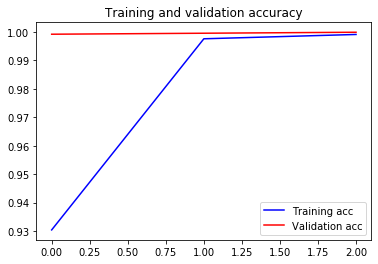

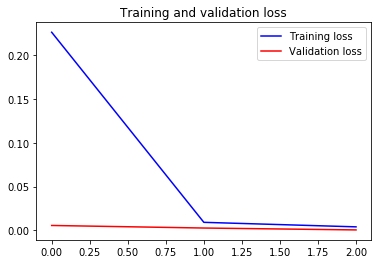

In [24]:
acc = do_train_model.history['acc']
val_acc = do_train_model.history['val_acc']
loss = do_train_model.history['loss']
val_loss = do_train_model.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [30]:
from keras.models import load_model
# model = load_model('/home/atif/machine_learning_stuff/model_file_keras/general_2_sep_ep_30_epoch.h5')
model = load_model('/home/atif/machine_learning_stuff/model_file_keras/2019-09-12 11:50:23.860700_30.h5')

In [26]:
import pandas as pd
test = pd.read_csv('/home/atif/machine_learning_stuff/ml_image/test_image_keras_IAI.csv',sep=';')
# test_image_path =  '/home/atif/machine_learning_stuff/ml_image/test_image_crop/'

X_test = []
y_test = []
i = 0
for file_name, class_id  in zip(list(test['Filename']), list(test['ClassId'])):
    print('filename: ',file_name,'\t classId: ',class_id)
    #print('classId: ',class_id)
    img_path = os.path.join('/home/atif/machine_learning_stuff/ml_image/test_image_26_aug/',file_name)
#     img_path = glob.glob(os.path.join(test_image_path, '*/*.jpg'))
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    
X_test = np.array(X_test)
y_test = np.array(y_test)

filename:  denkmit_edelstahk_reiniger (1).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (2).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (3).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (4).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (5).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (6).jpg 	 classId:  5
filename:  denkmit_edelstahk_reiniger (7).jpg 	 classId:  5
filename:  denkmit_Entkalker (1).jpg 	 classId:  7
filename:  denkmit_Entkalker (2).jpg 	 classId:  7
filename:  denkmit_Entkalker (3).jpg 	 classId:  7
filename:  denkmit_Entkalker (4).jpg 	 classId:  7
filename:  denkmit_Entkalker (5).jpg 	 classId:  7
filename:  denkmit_Entkalker (6).jpg 	 classId:  7
filename:  denkmit_geschirrreiniger_REVOLUTION (1).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (2).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (3).jpg 	 classId:  10
filename:  denkmit_geschirrreiniger_REVOLUTION (4).jpg 	 classId

In [31]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.6966292134831461
